## Assignment: Object detection
- Alumno 1: José María De Miguel
- Alumno 2: Miguel Ángel Rojo
- Alumno 3: Sandra Millán

The goals of the assignment are:
* Put into practice acquired knowledge to detect and recognize objects of interest within a satellite image.

To address this problem, you must choose one of the following options:
*	Implement a sliding window strategy to process the whole image, and then train a classifier that determines whether each window includes or not an object of interest. In this way, you can use previous image classification model to infer the object category.
*	Build a single-stage object detection model (e.g., YOLO, SSD, RetinaNet, etc.).
*	Build a two-stage object detection model (e.g., Faster R-CNN, R-FCN, etc.).

Follow the link below to download the detection data set “xview_detection”: [https://drive.upm.es/s/P7nEf3Bygns7tbM](https://drive.upm.es/s/P7nEf3Bygns7tbM)

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 93.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2025-12-01 10:01:18.138124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764583278.302213      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764583278.352296      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Small car', 1: 'Bus', 2: 'Truck', 3: 'Building'}

In [5]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('/kaggle/input/xview-detection/' + filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a detector to deal with the “xview_detection” perception task.

In [6]:
import json

# Load database
json_file = '/kaggle/input/xview-detection/xview_det_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [7]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img in json_data['images'].values():
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    for json_ann in [elem for elem in json_data['annotations'].values() if elem['image_id'] == json_img['image_id']]:
        obj = GenericObject()
        obj.id = json_ann['image_id']
        obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
        obj.category = json_ann['category_id']
        counts[obj.category] += 1
        image.add_object(obj)
    anns.append(image)
print(counts)

{'Small car': 188300, 'Bus': 6269, 'Truck': 10600, 'Building': 275943}


In [8]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 6845
Number of validation images: 761


In [9]:
# Load architecture
import keras_cv

print('Load model')
prediction_decoder = keras_cv.layers.NonMaxSuppression(bounding_box_format='xyxy', from_logits=False, confidence_threshold=0.2, iou_threshold=0.7)
model = keras_cv.models.YOLOV8Detector.from_preset(preset='yolo_v8_xs_backbone_coco', num_classes=len(categories), load_weights=True, bounding_box_format='xyxy', prediction_decoder=prediction_decoder)
# model.summary()

Load model


I0000 00:00:1764583631.157124      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
from tensorflow.keras.optimizers import SGD

# Learning rate is changed to 0.001
opt = SGD(learning_rate=1e-3, momentum=0.9, global_clipnorm=10.0)
model.compile(optimizer=opt, classification_loss='binary_crossentropy', box_loss='ciou', jit_compile=False)

In [11]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_loss', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [12]:
def image_generator(filename, tile, bboxes, categories):
    def load_sample(filepath):
        image = load_geoimage(filepath.numpy().decode('utf-8'))
        return tf.cast(image, tf.uint8)
    # Load image
    img = tf.squeeze(tf.py_function(func=load_sample, inp=[filename], Tout=[tf.uint8]), axis=0)  # tf.print(tf.shape(img)) -> [H, W, 3]
    img_roi = tf.image.pad_to_bounding_box(img, 0, 0, 640, 640)
    return {'images': tf.cast(img_roi, tf.float32), 'bounding_boxes': {'boxes': bboxes, 'classes': categories}}

def ragged_to_dense(inputs):
    from keras_cv import bounding_box
    return {'images': inputs['images'].to_tensor(), 'bounding_boxes': bounding_box.to_dense(inputs['bounding_boxes'], max_boxes=2000)}

def dict_to_tuple(inputs):
    return inputs['images'], inputs['bounding_boxes']

In [13]:
# Generate the list of objects from annotations
filenames_train, tiles_train, bboxes_train, categories_train = zip(*list(map(lambda img_ann: (img_ann.filename, list(img_ann.tile), list([list(obj_ann.bb) for obj_ann in img_ann.objects]), list([list(categories.keys())[list(categories.values()).index(obj_ann.category)] for obj_ann in img_ann.objects])), anns_train)))
filenames_valid, tiles_valid, bboxes_valid, categories_valid = zip(*list(map(lambda img_ann: (img_ann.filename, list(img_ann.tile), list([list(obj_ann.bb) for obj_ann in img_ann.objects]), list([list(categories.keys())[list(categories.values()).index(obj_ann.category)] for obj_ann in img_ann.objects])), anns_valid)))
ds_train = tf.data.Dataset.from_tensor_slices((tf.cast(filenames_train, tf.string), tf.cast(tiles_train, tf.int32), tf.cast(tf.ragged.constant(bboxes_train), tf.float32).to_tensor(), tf.cast(tf.ragged.constant(categories_train), tf.float32).to_tensor()))
ds_valid = tf.data.Dataset.from_tensor_slices((tf.cast(filenames_valid, tf.string), tf.cast(tiles_valid, tf.int32), tf.cast(tf.ragged.constant(bboxes_valid), tf.float32).to_tensor(), tf.cast(tf.ragged.constant(categories_valid), tf.float32).to_tensor()))
ds_train = ds_train.map(image_generator, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.map(image_generator, num_parallel_calls=tf.data.AUTOTUNE)
# Generators
batch_size = 4
ds_train = ds_train.shuffle(batch_size*5)
ds_train = ds_train.ragged_batch(batch_size=batch_size, drop_remainder=True)
ds_valid = ds_valid.ragged_batch(batch_size=batch_size, drop_remainder=True)
data_augmentation = tf.keras.Sequential(
    layers=[keras_cv.layers.RandomFlip(mode='horizontal_and_vertical', bounding_box_format='xyxy'),
            keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, bounding_box_format='xyxy'),
            keras_cv.layers.RandomColorDegeneration(factor=0.5)])
ds_train = ds_train.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
# Bounding box tensors need to be Dense instead of Ragged
ds_train = ds_train.map(ragged_to_dense, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.map(ragged_to_dense, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
ds_valid = ds_valid.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [14]:
import numpy as np

print('Training model')
epochs = 40
train_steps, valid_steps = len(ds_train), len(ds_valid)
h = model.fit(ds_train, steps_per_epoch=train_steps, validation_data=ds_valid, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmin(h.history['val_loss']))
best_value = np.min(h.history['val_loss'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_loss ' + str(best_value))

Training model
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, None))
  warnings.warn(msg)
I0000 00:00:1764583667.848030      67 service.cc:148] XLA service 0x7dcba5930320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764583667.848700      67 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764583667.910759      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764583669.417604      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1711/1711 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - box_loss: 3.1674 - class_loss: 11.3556 - loss: 14.5230

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, None))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 2.89591, saving model to model.keras
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 608s 335ms/step - box_loss: 3.1671 - class_loss: 11.3509 - loss: 14.5180 - val_box_loss: 2.4005 - val_class_loss: 0.4954 - val_loss: 2.8959 - learning_rate: 0.0010
Epoch 2/40
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - box_loss: 2.3163 - class_loss: 0.5123 - loss: 2.8285
Epoch 2: val_loss improved from 2.89591 to 2.76957, saving model to model.keras
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 536s 313ms/step - box_loss: 2.3163 - class_loss: 0.5122 - loss: 2.8285 - val_box_loss: 2.3336 - val_class_loss: 0.4360 - val_loss: 2.7696 - learning_rate: 0.0010
Epoch 3/40
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - box_loss: 2.2219 - class_loss: 0.4618 - loss: 2.6838
Epoch 3: val_loss improved from 2.76957 to 2.67379, saving model to model.keras
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 536s 313ms/step - box_loss: 2.2219 - class_loss: 0.4618 - loss: 2.6838 - val_box_loss: 2.2586 - val_class_loss: 0.4152 - v

In [15]:
with open("history_FT.json", "w") as f:
    json.dump(h.history, f)

model.save("YOLOV8-1.keras")

#### Validation
Compute validation metrics.

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
%matplotlib inline

def area_intersection(boxes, box):
    xmin = np.maximum(np.min(boxes[:, 0::2], axis=1), np.min(box[0::2]))
    ymin = np.maximum(np.min(boxes[:, 1::2], axis=1), np.min(box[1::2]))
    xmax = np.minimum(np.max(boxes[:, 0::2], axis=1), np.max(box[0::2]))
    ymax = np.minimum(np.max(boxes[:, 1::2], axis=1), np.max(box[1::2]))
    w = np.maximum(xmax - xmin + 1.0, 0.0)
    h = np.maximum(ymax - ymin + 1.0, 0.0)
    return w * h

def area_union(boxes, box):
    area_anns = (np.max(box[0::2])-np.min(box[0::2])+1.0) * (np.max(box[1::2])-np.min(box[1::2])+1.0)
    area_pred = (np.max(boxes[:, 0::2], axis=1)-np.min(boxes[:, 0::2], axis=1)+1.0) * (np.max(boxes[:, 1::2], axis=1)-np.min(boxes[:, 1::2], axis=1)+1.0)
    return area_anns + area_pred - area_intersection(boxes, box)

def calc_iou(boxes, box):
    iou = area_intersection(boxes, box) / area_union(boxes, box)
    max_value = np.max(iou)
    max_index = np.argmax(iou)
    return max_value, max_index

def calc_ap(rec, prec):
    # First append sentinel values at the end
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec, [0.0]))
    # Compute the precision envelope
    for i in range(mpre.size-1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])
    # To calculate area under PR curve, look for points where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]
    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i+1] - mrec[i]) * mpre[i+1])
    return ap

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

def draw_precision_recall(precisions, recalls, categories):
    # Draw precision-recall curves for each category
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    plt.axis([0, 1, 0, 1])
    c_dark = list(filter(lambda x: x.startswith('dark'), col.cnames.keys()))
    aps = []
    # Compare categories for a specific algorithm
    for idx in range(len(categories)):
        plt.plot(recalls[idx], precisions[idx], color=c_dark[idx], label=categories[idx], linewidth=4.0)
        aps.append(calc_ap(recalls[idx], precisions[idx]))
    handles, labels = ax.get_legend_handles_labels()
    labels = [str(val + ' [' + "{:.3f}".format(aps[idx]) + ']') for idx, val in enumerate(labels)]
    handles = [h for (ap, h) in sorted(zip(aps, handles), key=lambda x: x[0], reverse=True)]
    labels = [l for (ap, l) in sorted(zip(aps, labels), key=lambda x: x[0], reverse=True)]
    leg = plt.legend(handles, labels, loc='upper right')
    leg.set_zorder(100)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid("on", linestyle="--", linewidth=2.0)
    fig.tight_layout()
    plt.show()

In [17]:
import numpy as np
from tqdm import tqdm

#model.load_weights('model.keras')
# Generate the list of objects from annotations
ds_valid = tf.data.Dataset.from_tensor_slices((tf.cast(filenames_valid, tf.string), tf.cast(tiles_valid, tf.int32), tf.cast(tf.ragged.constant(bboxes_valid), tf.float32).to_tensor(), tf.cast(tf.ragged.constant(categories_valid), tf.float32).to_tensor()))
ds_valid = ds_valid.map(image_generator, num_parallel_calls=tf.data.AUTOTUNE).cache()
ds_valid = ds_valid.batch(batch_size=1)
ds_valid = ds_valid.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
# Process each tile sequentially
iterator = iter(ds_valid)
annotations, predictions = {}, {}
for ann in tqdm(anns_valid):
    # Save annotations
    annotations.setdefault(ann.filename, {})
    predictions.setdefault(ann.filename, {})
    for obj in ann.objects:
        annotations[ann.filename].setdefault(obj.category, {'bbox': []})
        annotations[ann.filename][obj.category]['bbox'].append(obj.bb)
    # Save prediction
    image, _ = next(iterator)
    y_pred = model.predict(image, verbose=0)
    for i in range(np.squeeze(y_pred['num_detections'])):
        obj = GenericObject()
        bbox = np.squeeze(y_pred['boxes'])[i]
        obj.bb = (bbox[0], bbox[1], bbox[2], bbox[3])
        obj.category = categories[np.squeeze(y_pred['classes'])[i]]
        obj.score = np.squeeze(y_pred['confidence'])[i]
        predictions[ann.filename].setdefault(obj.category, {'bbox': [], 'confidence': []})
        predictions[ann.filename][obj.category]['bbox'].append(obj.bb)
        predictions[ann.filename][obj.category]['confidence'].append(obj.score)  # sort detections by confidence

  0%|          | 0/761 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 640, 640, 3))
  warnings.warn(msg)
100%|██████████| 761/761 [01:40<00:00,  7.57it/s]


In [18]:
threshold = 0.5
default_cls = 'BACKGROUND'
y_true, y_pred = [], []  # confusion matrix
tps, confidences = dict(), dict()  # draw precision-recall curves for each category
for cls in categories.values():
    # Compute TP, FP and FN for each image
    tps[cls], confidences[cls] = [], []
    for f in predictions:
        # Sort 'cls' predictions by confidence for each file
        pred_boxes, pred_confidences = [], []
        if cls in predictions[f].keys():
            for idx in range(len(predictions[f][cls]['bbox'])):
                pred_boxes.append(predictions[f][cls]['bbox'][idx])
                pred_confidences.append(predictions[f][cls]['confidence'][idx])
            sorted_ind = np.argsort(-np.array(pred_confidences))
            pred_boxes = np.array(pred_boxes)[sorted_ind, :]
        pred_boxes = np.array(pred_boxes).astype(float)
        # Define 'cls' annotations for each file
        anno_boxes = []
        if cls in annotations[f].keys():
            anno_boxes = annotations[f][cls]['bbox']
        anno_boxes = np.array(anno_boxes).astype(float)
        # Define horizontal or oriented bounding boxes
        anno_indices = list(range(len(anno_boxes)))
        # Compare a single prediction 'pred_box' with all annotations 'anno_boxes'
        for pred_idx, pred_box in enumerate(pred_boxes):
            # A prediction is correct if its IoU with the ground truth is above the threshold
            iou_value, ann_index = calc_iou(anno_boxes, pred_box) if len(anno_boxes) > 0 else (-1, -1)
            if iou_value > threshold and ann_index in anno_indices:
                # TP
                anno_indices.remove(int(ann_index))
                tps[cls] += [1.0]
                y_true += [cls]
            else:
                # FP
                tps[cls] += [0.0]
                y_true += [default_cls]
            y_pred += [cls]
            confidences[cls] += [pred_confidences[pred_idx]]
        # FN
        y_true += [cls] * len(anno_indices)
        y_pred += [default_cls] * len(anno_indices)
y_true, y_pred = np.array(y_true), np.array(y_pred)

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

# Compute AP metric
precision_list, recall_list, ap_list = [], [], []
for cls in categories.values():
    sorted_ind = np.argsort(-np.array(confidences[cls]))
    tp = np.cumsum(np.array(tps[cls])[sorted_ind], dtype=float)
    recall = np.array([0.0]) if len(tp) == 0 else tp / np.maximum(np.sum(y_true == cls), np.finfo(np.float64).eps)
    precision = np.array([0.0]) if len(tp) == 0 else tp / np.maximum(list(range(1, np.sum(y_pred == cls)+1)), np.finfo(np.float64).eps)
    ap = calc_ap(recall, precision)
    print('> %s: Recall: %.3f%% Precision: %.3f%% AP: %.3f%%' % (cls, recall[-1]*100, precision[-1]*100, ap*100))
    precision_list.append(precision)
    recall_list.append(recall)
    ap_list.append(ap)
mean_ap = np.mean(ap_list)
print('mAccuracy: %.3f%%' % (accuracy_score(y_true, y_pred)*100))
print('mRecall: %.3f%%' % (recall_score(y_true, y_pred, average='macro', zero_division=1)*100))
print('mPrecision: %.3f%%' % (precision_score(y_true, y_pred, average='macro', zero_division=1)*100))
print('mAP: %.3f%%' % (mean_ap*100))

> Small car: Recall: 52.837% Precision: 64.011% AP: 42.910%
> Bus: Recall: 5.469% Precision: 30.435% AP: 2.543%
> Truck: Recall: 0.096% Precision: 12.500% AP: 0.024%
> Building: Recall: 47.474% Precision: 58.961% AP: 38.997%
mAccuracy: 36.562%
mRecall: 21.175%
mPrecision: 33.181%
mAP: 21.119%


Confusion matrix:
[[    0  5199    80     7  9489]
 [ 8254  9247     0     0     0]
 [  605     0    35     0     0]
 [ 1043     0     0     1     0]
 [15084     0     0     0 13633]]


/tmp/ipykernel_20/2574756117.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


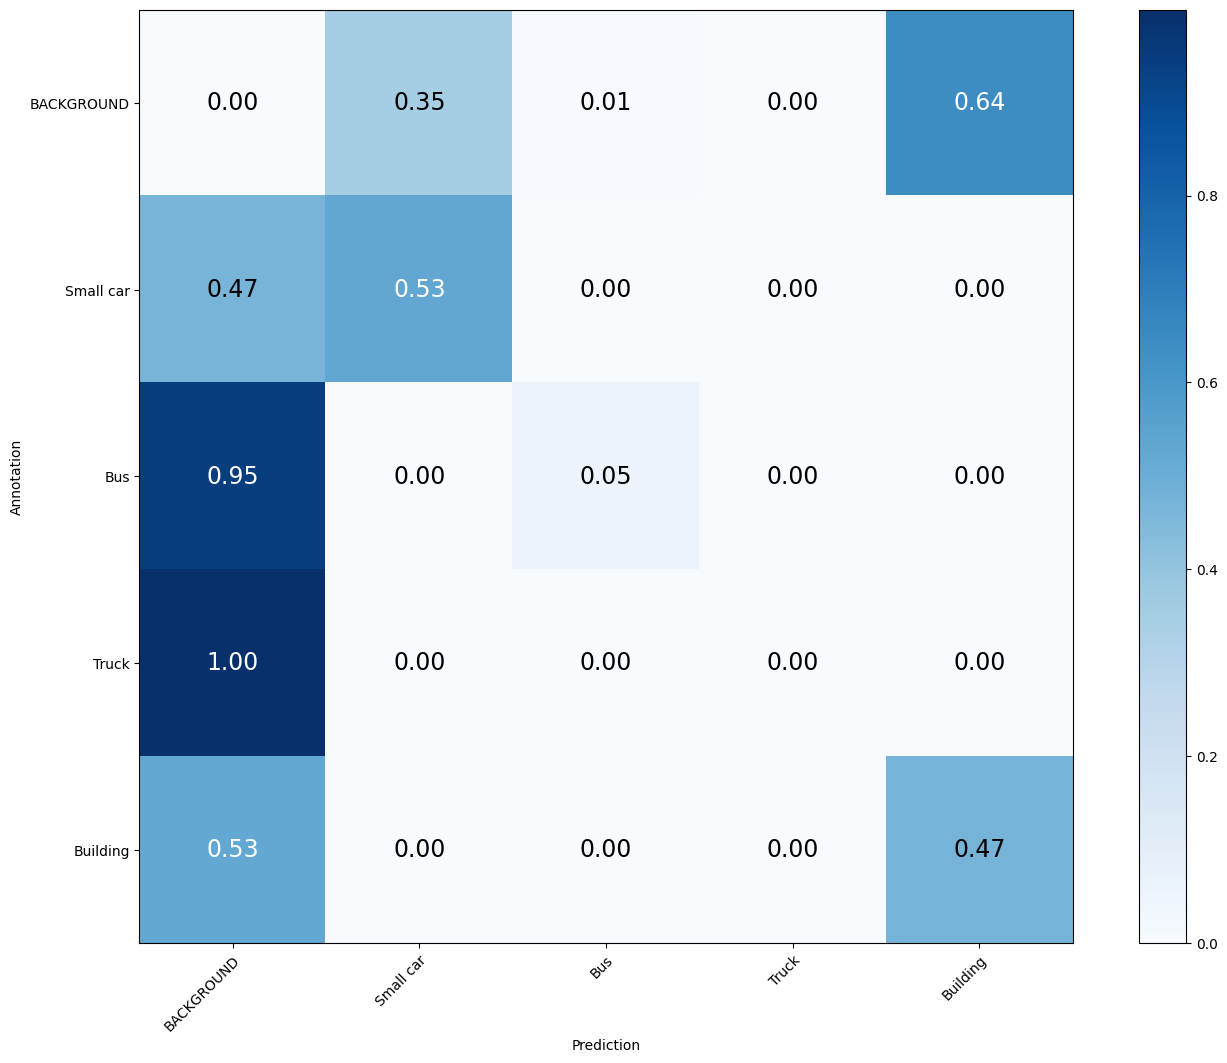

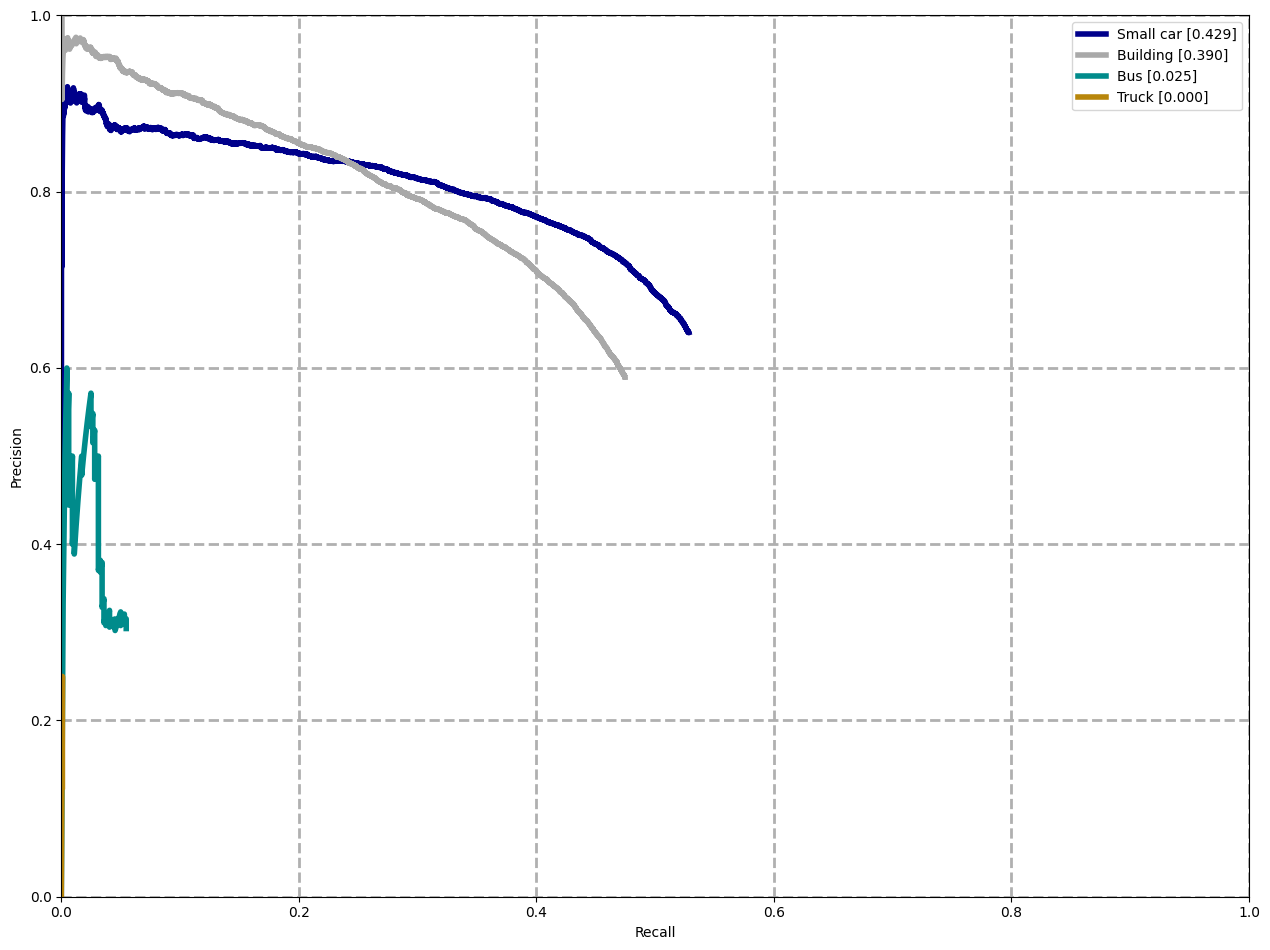

In [20]:
names = list(categories.values()).copy()
names.insert(0, default_cls)
cm = confusion_matrix(y_true, y_pred, labels=names)
print('Confusion matrix:')
print(cm)
draw_confusion_matrix(cm, names)
draw_precision_recall(precision_list, recall_list, categories)